# ice-WEDGE Prediction Tool

This notebook predicts the heterogeneous nucleation temperature (`Thet`) and geometry of ice nuclei in wedge-shaped surface defects based on user input. The model is built on GPR fits to HINT-calculated data.

# === 1. SETUP AND IMPORTS ===

In [51]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# === 2. USER INPUT ===

In [64]:
# User inputs
Tflat_input = 252.0   # Temperature of the flat surface in K (valid range: 242–272 K)
angle_input = 109      # Wedge angle in degrees (valid range: 20–179°)
depth_input = 50      # Depth of the wedge in nm

# Input validation
assert 242 <= Tflat_input <= 272, "Tflat_input must be between 242 and 272 K"
assert 20 <= angle_input <= 179, "angle_input must be between 20 and 179 degrees"

# === 3. LOAD DATA ===

In [65]:
os.chdir('/Users/iribeiro/Documents/Box Sync/molinero/wedge-iceNucleation/')
file_path = 'data-GPR-model.xlsx'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"{file_path} not found. Please check the path.")

# Read Excel
df = pd.read_excel(file_path)


# === 4. TRAIN GPR MODELS ===

In [66]:
# Opening width calculation
def calculate_opening_width(R, angle_eta_deg):
    angle_eta_rad = np.radians(angle_eta_deg)
    return 2 * R * np.sin(angle_eta_rad / 2)

def binding_energy_from_flat_surface(x):
    poly_fit=np.array([-3.59991606e-04,2.87541193e-01,-7.75121523e+01,6.99302301e+03])
    binding_energy = poly_fit[0]*x**3+poly_fit[1]*x**2+poly_fit[2]*x**1+poly_fit[3]
    return binding_energy
    
D_target = calculate_opening_width(depth_input,angle_input)          # opening width in nm
binding_energy_input = binding_energy_from_flat_surface(Tflat_input) # Binding energy in mJ/m²

X_model = df[['η', 'Binding Energy']]

# Targets
targets = {
    'Thet': df['Thet'],
    'ΔG': df['ΔG'],
    'N': np.log10(df['N']),
    'R': np.log10(df['R']),
    'α': df['α'],
    'ψ': df['ψ'],
}

models = {}
for name, target in targets.items():
    if name=='Thet':
       kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[10]*2, length_scale_bounds=(240, 273))
    if name=='R':
       kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[10]*2, length_scale_bounds=(1e-2, 1e4))
    if name=='α':
       kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[10]*2, length_scale_bounds=(1e-2, 1e4))
    if name=='N':
       kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[10]*2, length_scale_bounds=(1e-2, 1e4))
    if name=='ψ':
       kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[10]*2, length_scale_bounds=(1e-1, 380))
    else:
       kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=[10]*2, length_scale_bounds=(1e-2, 1e4))
    model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-3, normalize_y=True)
    model.fit(X_model, target)
    models[name] = model
    
print("Done!")

Done!


# === 5. PREDICT FROM USER INPUT ===

In [67]:
def predict_from_user_input(angle_user, binding_user):
    user_input = np.array([[angle_user, binding_user]])
    results = {}
    if angle_user != 180: 
       print(f"\nUser Input\nAngle (η): {angle_user}°\nTflat: {Tflat_input:.1f} K (Binding Energy: {binding_user:.2f} mJ/m²)")
       print(f"\nDepth: {depth_input:.2f} nm, opening width: {D_target:.2f} nm\n\nPredictions")
    for name, model in models.items():
       pred, std = model.predict(user_input, return_std=True)  
       if name=='N' or name=='R':
          pred = 10**(pred); std=10**(std)
       results[name] = (pred[0], std[0])
       if angle_user != 180: 
          print(f"{name}: {pred[0]:.1f} ± {std[0]:.1f}")
    return results

results = predict_from_user_input(angle_input, binding_energy_input)
Thet_in = results['Thet'][0]
deltaG_in = results['ΔG'][0]
N_in = results['N'][0]
R_in = results['R'][0]
alpha_in = results['α'][0]
psi_in = results['ψ'][0]

theta_in = math.radians(alpha_in)-np.pi/2+math.radians(angle_input)/2 
a_in = R_in*np.sin(theta_in)
wd_in= a_in/np.tan(math.radians(angle_input)/2)   

print(f"\nθ: {math.degrees(theta_in):.1f}")
print(f"Width of critical nucleus: {2*a_in:.1f} nm")
print(f"Wedge depth to fit critical nucleus: {wd_in:.1f} nm")


User Input
Angle (η): 109°
Tflat: 252.0 K (Binding Energy: -40.97 mJ/m²)

Depth: 50.00 nm, opening width: 81.41 nm

Predictions
Thet: 259.5 ± 0.1
ΔG: 51.7 ± 0.0
N: 920.3 ± 1.0
R: 3.7 ± 1.0
α: 73.9 ± 0.1
ψ: 162.9 ± 28.1

θ: 38.4
Width of critical nucleus: 4.7 nm
Wedge depth to fit critical nucleus: 1.7 nm


# === 6. ESTIMATE Thet_out FROM FLAT SURFACE CURVE ===

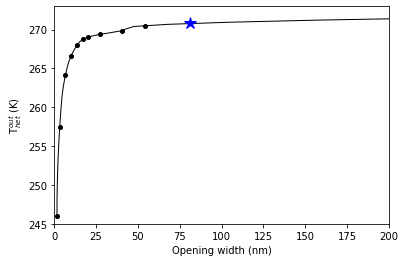

In [89]:
flat_file = 'HINT_DATA_FLAT_SURFACE.txt'
if not os.path.exists(flat_file):
    raise FileNotFoundError(f"{flat_file} not found.")

data = np.loadtxt(flat_file, usecols=[0, 1])
D_raw = data[:, 0] * 3.4
T_kelvin = 273.15 + data[:, 1]

D_raw = np.append(D_raw, 1e3)
T_kelvin = np.append(T_kelvin,273.15)

interpolator = interp1d(T_kelvin, D_raw, kind='quadratic', fill_value="extrapolate")

T_interp = np.linspace(min(T_kelvin), max(T_kelvin), 100)
D_interp = interpolator(T_interp)

# Root solving
if D_target < min(D_interp): 
   Thet_out = min(T_interp)
#elif D_target > max(D_interp):
#   Thet_out = max(T_interp)
else:
   def equation(T): return interpolator(T) - D_target
   result = root_scalar(equation, bracket=[min(T_interp), max(T_interp)])
   Thet_out = result.root if result.converged else np.nan

fig, ax = plt.subplots()
ax.plot(D_interp, T_interp, lw=1, color='black')
ax.plot(D_raw, T_kelvin, marker='o', color='black',lw=0,ms=4)
ax.plot(D_target, Thet_out, color='blue',ms=12,marker='*')
ax.set_ylabel('T$_{het}^{out}$ (K)')
ax.set_xlabel('Opening width (nm)')
ax.set_xlim(0, 200)
ax.set_ylim(245,273)

plt.show()

# === 7. FINAL OUTPUT ===

In [86]:
print(f"\nUser Input\nAngle (η): {angle_input}°")
print(f"Tflat (Thet at 180°): {Tflat_input:.1f} K (Binding Energy: {binding_energy_input:.2f} mJ/m²)")
print(f"Depth: {depth_input:.2f} nm, opening width: {D_target:.2f} nm\n")

print(f"Thet inside the wedge: {Thet_in:.1f} K")
print(f"Thet for a flat surface: {Thet_out:.1f} K")

Tfinal = min(Thet_in, Thet_out)
barrier = "ΔGin (nucleation inside the wedge)" if Tfinal == Thet_in else "ΔGout (growth outside the wedge)"

print(f"\nPredicted nucleation temperature (Thet): {Tfinal:.1f} K")
print(f"Dominant barrier: {barrier}")


User Input
Angle (η): 109°
Tflat (Thet at 180°): 252.0 K (Binding Energy: -40.97 mJ/m²)
Depth: 50.00 nm, opening width: 81.41 nm

Thet inside the wedge: 259.5 K
Thet for a flat surface: 270.8 K

Predicted nucleation temperature (Thet): 259.5 K
Dominant barrier: ΔGin (nucleation inside the wedge)


# === 8. PLOTS ===

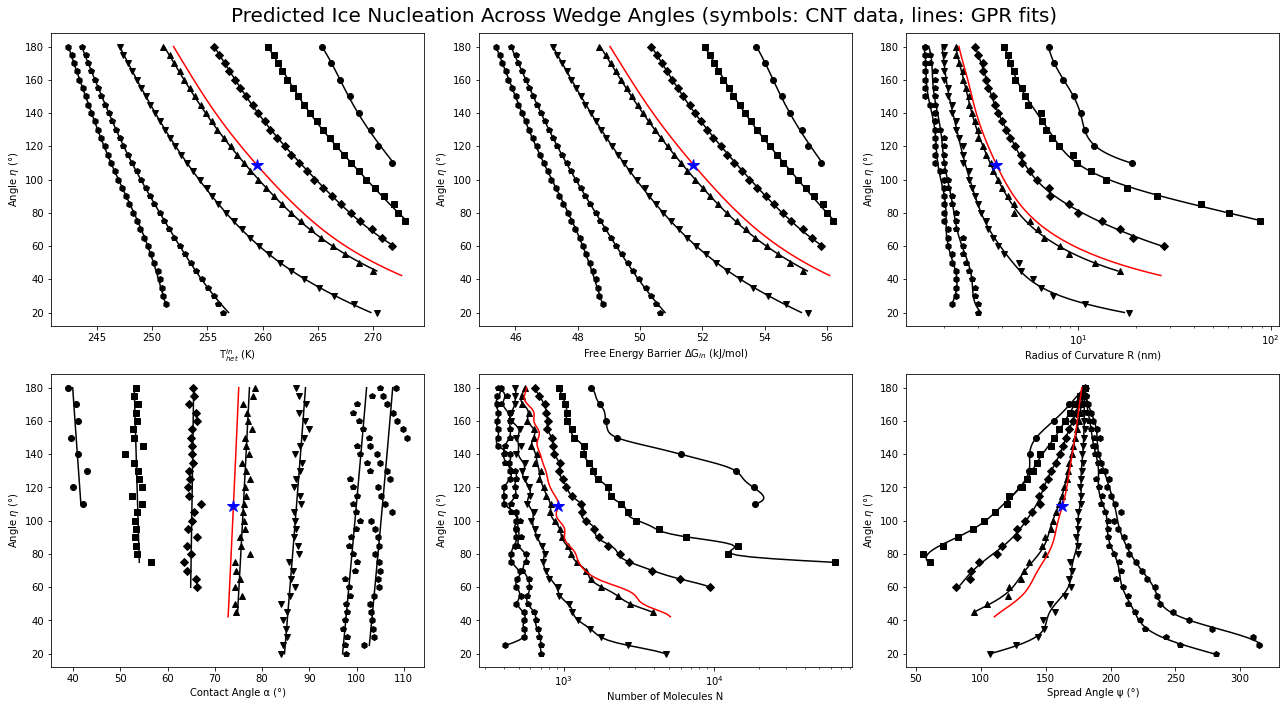

In [87]:
df = pd.read_excel(file_path)
eta = df['η'].to_numpy()
thet = df['Thet'].to_numpy()
binding_energy = df['Binding Energy'].to_numpy()
N = df['N'].to_numpy()
deltaG = df['ΔG'].to_numpy()
R = df['R'].to_numpy()
alpha = df['α'].to_numpy()
psi = df['ψ'].to_numpy()

markers = np.array(["o","s","D","^","v","p","h","*","x"])

# Plot 'T_het' vs 'η' for different 'Binding Energy'
unique_binding_energies = df['Binding Energy'].unique()

# Create figure and axes
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()  # Flatten to index easily

# Plotting
count=0
for energy in unique_binding_energies:
    mask = binding_energy == energy
    eta_subset = eta[mask]
    thet_subset = thet[mask]
    R_subset = R[mask]
    alpha_subset = alpha[mask]
    psi_subset = psi[mask]
    N_subset = N[mask]
    deltaG_subset = deltaG[mask]

    axs[0].plot(thet_subset, eta_subset, marker=markers[count], lw=0, color='black')
    axs[1].plot(deltaG_subset, eta_subset, marker=markers[count], lw=0, color='black')
    axs[2].plot(R_subset, eta_subset, marker=markers[count], lw=0, color='black')
    axs[3].plot(alpha_subset, eta_subset, marker=markers[count], lw=0, color='black')
    axs[4].plot(N_subset, eta_subset, marker=markers[count], lw=0, color='black')
    axs[5].plot(psi_subset, eta_subset, marker=markers[count], lw=0, color='black')
    count=count+1
    angle_range = np.linspace(min(eta_subset), 180, 100)
    
    X_query = np.column_stack([angle_range, np.full_like(angle_range, energy)])
    
    # Predict Thet using the trained GPR model
    Thet_model = models['Thet']
    Thet_pred, Thet_std = Thet_model.predict(X_query, return_std=True)
    axs[0].plot(Thet_pred,angle_range, color='black',lw=1.5)
    
    deltaG_model = models['ΔG']
    deltaG_pred, deltaG_std = deltaG_model.predict(X_query, return_std=True)
    axs[1].plot(deltaG_pred,angle_range, color='black',lw=1.5)
    
    R_model = models['R']
    R_pred, R_std = R_model.predict(X_query, return_std=True)
    axs[2].plot(10**(R_pred),angle_range, color='black',lw=1.5)
    
    alpha_model = models['α']
    alpha_pred, alpha_std = alpha_model.predict(X_query, return_std=True)
    axs[3].plot(alpha_pred,angle_range, color='black',lw=1.5)
    
    N_model = models['N']
    N_pred, N_std = N_model.predict(X_query, return_std=True)
    axs[4].plot(10**(N_pred),angle_range, color='black',lw=1.5)
    
    psi_model = models['ψ']
    psi_pred, psi_std = psi_model.predict(X_query, return_std=True)
    axs[5].plot(psi_pred,angle_range, color='black',lw=1.5)
    
# user 
    
X_query = np.column_stack([angle_range, np.full_like(angle_range, binding_energy_input)])
Thet_model = models['Thet']
Thet_pred, Thet_std = Thet_model.predict(X_query, return_std=True)
mask = Thet_pred < 273
axs[0].plot(Thet_pred[mask], angle_range[mask], color='red', ls='-')
axs[0].plot(Thet_in, angle_input, color='blue',ms=12,marker='*')
    
X_query = np.column_stack([angle_range, np.full_like(angle_range, binding_energy_input)])
deltaG_model = models['ΔG']
deltaG_pred, deltaG_std = deltaG_model.predict(X_query, return_std=True)
axs[1].plot(deltaG_pred[mask], angle_range[mask], color='red',ls='-')
axs[1].plot(deltaG_in, angle_input, color='blue',ms=12,marker='*')
    
X_query = np.column_stack([angle_range, np.full_like(angle_range, binding_energy_input)])
R_model = models['R']
R_pred, R_std = R_model.predict(X_query, return_std=True)
axs[2].plot(10**(R_pred[mask]), angle_range[mask], color='red',ls='-')
axs[2].plot(R_in, angle_input, color='blue',ms=12,marker='*')
    
X_query = np.column_stack([angle_range, np.full_like(angle_range, binding_energy_input)])
alpha_model = models['α']
alpha_pred, alpha_std = alpha_model.predict(X_query, return_std=True)
axs[3].plot(alpha_pred[mask], angle_range[mask], color='red',ls='-')
axs[3].plot(alpha_in, angle_input, color='blue',ms=12,marker='*')
    
X_query = np.column_stack([angle_range, np.full_like(angle_range, binding_energy_input)])
N_model = models['N']
N_pred, N_std = N_model.predict(X_query, return_std=True)
axs[4].plot(10**(N_pred[mask]), angle_range[mask], color='red',ls='-')
axs[4].plot(N_in, angle_input, color='blue',ms=12,marker='*')
    
X_query = np.column_stack([angle_range, np.full_like(angle_range, binding_energy_input)])
psi_model = models['ψ']
psi_pred, psi_std = psi_model.predict(X_query, return_std=True)
axs[5].plot(psi_pred[mask], angle_range[mask], color='red',ls='-')
axs[5].plot(psi_in, angle_input, color='blue',ms=12,marker='*')

axs[0].set_ylabel('Angle $\\eta$ (°)')
axs[0].set_xlabel('T$_{het}^{in}$ (K)')

axs[1].set_ylabel('Angle $\\eta$ (°)')
axs[1].set_xlabel('Free Energy Barrier ΔG$_{in}$ (kJ/mol)')

axs[2].set_ylabel('Angle $\\eta$ (°)')
axs[2].set_xlabel('Radius of Curvature R (nm)')
axs[2].set_xscale('log')

axs[3].set_ylabel('Angle $\\eta$ (°)')
axs[3].set_xlabel('Contact Angle α (°)')

axs[4].set_ylabel('Angle $\\eta$ (°)')
axs[4].set_xlabel('Number of Molecules N')
axs[4].set_xscale('log')

axs[5].set_ylabel('Angle $\\eta$ (°)')
axs[5].set_xlabel('Spread Angle ψ (°)')

fig.suptitle('Predicted Ice Nucleation Across Wedge Angles (symbols: CNT data, lines: GPR fits)', fontsize=20)
plt.tight_layout()
plt.show()